In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import math
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from ddpm import *
import utils
from diffusers import UNet2DModel, DDIMScheduler

/nethome/zwang910/file_storage/miniconda3/envs/dl/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
cl_train_loaders, cl_test_loaders, train_loader, test_loader = utils.get_cl_dataset('mnist', batch_size=64, normalize=False)

Building DataLoaders for each class in train dataset...


100%|██████████| 60000/60000 [00:04<00:00, 13852.35it/s]


Building DataLoaders for each class in MNIST test dataset...


100%|██████████| 10000/10000 [00:00<00:00, 14037.98it/s]


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
class vae(nn.Module):
    def __init__(self, in_channels=1, latent_dim=8):
        super(vae, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(), # output shape: (batch_size, 16 * 7 * 7)
        )
        self.fc_mu = nn.Linear(16 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(16 * 7 * 7, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (16, 7, 7)),
            nn.ConvTranspose2d(16, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, in_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    def decode(self, z):
        return self.decoder(z)
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_reconstructed = self.decode(z)
        return x_reconstructed, mu, logvar
def loss_function(recon_x, x, mu, logvar):
    # BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    MSE = F.mse_loss(recon_x, x, reduction='mean') * 784
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

In [8]:
# train on VAE
VAE = vae().to(device)
# print the nuymber of parameters
num_params = sum(p.numel() for p in VAE.parameters() if p.requires_grad)
print(f"Number of parameters in VAE: {num_params}")
vae_optimizer = torch.optim.Adam(VAE.parameters(), lr=1e-3)
for class_id, loader in cl_train_loaders.items():
    for epoch in tqdm(range(100)):
        # print(f"Epoch {epoch+1}/{num_epochs}")
        # pbar = tqdm(loader, desc="Training")
        for batch in loader:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)

            vae_optimizer.zero_grad()
            recon_images, mu, logvar = VAE(images)
            loss = loss_function(recon_images, images, mu, logvar)

            loss.backward()
            vae_optimizer.step()

        print(f"Epoch {epoch+1}/{100}, Loss: {loss.item()}")
        if epoch % 20 == 0:
            with torch.no_grad():
                sample_images = VAE.decode(torch.randn(64, 8).to(device)).cpu()
                torchvision.utils.save_image(sample_images, f"vae_samples_class_{class_id}_epoch_{epoch}.png", nrow=8, normalize=True)
    break

Number of parameters in VAE: 24561


  1%|          | 1/100 [00:01<02:42,  1.64s/it]

Epoch 1/100, Loss: 39.738685607910156


  2%|▏         | 2/100 [00:03<02:35,  1.59s/it]

Epoch 2/100, Loss: 22.324108123779297


  3%|▎         | 3/100 [00:04<02:31,  1.56s/it]

Epoch 3/100, Loss: 12.848118782043457


  4%|▍         | 4/100 [00:06<02:29,  1.55s/it]

Epoch 4/100, Loss: 13.603076934814453


  5%|▌         | 5/100 [00:07<02:27,  1.55s/it]

Epoch 5/100, Loss: 13.40062427520752


  6%|▌         | 6/100 [00:09<02:26,  1.56s/it]

Epoch 6/100, Loss: 12.716519355773926


  7%|▋         | 7/100 [00:10<02:25,  1.57s/it]

Epoch 7/100, Loss: 10.001188278198242


  8%|▊         | 8/100 [00:12<02:23,  1.56s/it]

Epoch 8/100, Loss: 11.27049732208252


  9%|▉         | 9/100 [00:14<02:22,  1.56s/it]

Epoch 9/100, Loss: 10.424915313720703


 10%|█         | 10/100 [00:15<02:20,  1.57s/it]

Epoch 10/100, Loss: 10.569781303405762


 11%|█         | 11/100 [00:17<02:19,  1.57s/it]

Epoch 11/100, Loss: 10.766281127929688


 12%|█▏        | 12/100 [00:18<02:17,  1.56s/it]

Epoch 12/100, Loss: 10.335453987121582


 13%|█▎        | 13/100 [00:20<02:15,  1.56s/it]

Epoch 13/100, Loss: 8.944941520690918


 14%|█▍        | 14/100 [00:21<02:15,  1.57s/it]

Epoch 14/100, Loss: 9.746665000915527


 15%|█▌        | 15/100 [00:23<02:13,  1.57s/it]

Epoch 15/100, Loss: 8.496850967407227


 16%|█▌        | 16/100 [00:25<02:10,  1.55s/it]

Epoch 16/100, Loss: 11.03941535949707


 17%|█▋        | 17/100 [00:26<02:08,  1.55s/it]

Epoch 17/100, Loss: 9.173999786376953


 18%|█▊        | 18/100 [00:28<02:07,  1.56s/it]

Epoch 18/100, Loss: 9.283159255981445


 19%|█▉        | 19/100 [00:29<02:05,  1.55s/it]

Epoch 19/100, Loss: 8.823396682739258


 20%|██        | 20/100 [00:31<02:03,  1.55s/it]

Epoch 20/100, Loss: 10.112895011901855


 21%|██        | 21/100 [00:32<02:02,  1.55s/it]

Epoch 21/100, Loss: 10.00229263305664


 22%|██▏       | 22/100 [00:34<02:01,  1.55s/it]

Epoch 22/100, Loss: 8.055123329162598


 23%|██▎       | 23/100 [00:35<01:59,  1.55s/it]

Epoch 23/100, Loss: 10.445891380310059


 24%|██▍       | 24/100 [00:37<01:58,  1.56s/it]

Epoch 24/100, Loss: 9.143285751342773


 25%|██▌       | 25/100 [00:38<01:56,  1.55s/it]

Epoch 25/100, Loss: 10.263476371765137


 26%|██▌       | 26/100 [00:40<02:00,  1.62s/it]

Epoch 26/100, Loss: 9.753288269042969


 27%|██▋       | 27/100 [00:42<01:57,  1.61s/it]

Epoch 27/100, Loss: 8.087589263916016


 28%|██▊       | 28/100 [00:43<01:54,  1.58s/it]

Epoch 28/100, Loss: 9.128582954406738


 29%|██▉       | 29/100 [00:45<01:51,  1.57s/it]

Epoch 29/100, Loss: 8.84188461303711


 30%|███       | 30/100 [00:46<01:49,  1.56s/it]

Epoch 30/100, Loss: 8.753609657287598


 31%|███       | 31/100 [00:48<01:46,  1.54s/it]

Epoch 31/100, Loss: 8.423911094665527


 32%|███▏      | 32/100 [00:49<01:44,  1.54s/it]

Epoch 32/100, Loss: 9.341291427612305


 33%|███▎      | 33/100 [00:51<01:42,  1.53s/it]

Epoch 33/100, Loss: 9.10908031463623


 34%|███▍      | 34/100 [00:52<01:40,  1.53s/it]

Epoch 34/100, Loss: 8.266468048095703


 35%|███▌      | 35/100 [00:54<01:38,  1.52s/it]

Epoch 35/100, Loss: 9.022558212280273


 36%|███▌      | 36/100 [00:56<01:37,  1.52s/it]

Epoch 36/100, Loss: 9.29061508178711


 37%|███▋      | 37/100 [00:57<01:35,  1.52s/it]

Epoch 37/100, Loss: 8.989148139953613


 38%|███▊      | 38/100 [00:59<01:34,  1.52s/it]

Epoch 38/100, Loss: 8.712841033935547


 39%|███▉      | 39/100 [01:00<01:32,  1.52s/it]

Epoch 39/100, Loss: 8.613250732421875


 40%|████      | 40/100 [01:02<01:31,  1.52s/it]

Epoch 40/100, Loss: 8.803369522094727


 41%|████      | 41/100 [01:03<01:29,  1.52s/it]

Epoch 41/100, Loss: 8.013100624084473


 42%|████▏     | 42/100 [01:05<01:28,  1.52s/it]

Epoch 42/100, Loss: 8.718862533569336


 43%|████▎     | 43/100 [01:06<01:26,  1.52s/it]

Epoch 43/100, Loss: 7.9287919998168945


 44%|████▍     | 44/100 [01:08<01:25,  1.53s/it]

Epoch 44/100, Loss: 9.299148559570312


 45%|████▌     | 45/100 [01:09<01:23,  1.52s/it]

Epoch 45/100, Loss: 8.391424179077148


 46%|████▌     | 46/100 [01:11<01:21,  1.52s/it]

Epoch 46/100, Loss: 8.750185012817383


 47%|████▋     | 47/100 [01:12<01:20,  1.51s/it]

Epoch 47/100, Loss: 8.263693809509277


 48%|████▊     | 48/100 [01:14<01:18,  1.51s/it]

Epoch 48/100, Loss: 8.496902465820312


 49%|████▉     | 49/100 [01:15<01:16,  1.50s/it]

Epoch 49/100, Loss: 9.332239151000977


 50%|█████     | 50/100 [01:17<01:14,  1.50s/it]

Epoch 50/100, Loss: 8.2341947555542


 51%|█████     | 51/100 [01:18<01:13,  1.49s/it]

Epoch 51/100, Loss: 8.962998390197754


 52%|█████▏    | 52/100 [01:20<01:11,  1.49s/it]

Epoch 52/100, Loss: 8.229813575744629


 53%|█████▎    | 53/100 [01:21<01:09,  1.49s/it]

Epoch 53/100, Loss: 9.375490188598633


 54%|█████▍    | 54/100 [01:23<01:08,  1.48s/it]

Epoch 54/100, Loss: 9.199180603027344


 55%|█████▌    | 55/100 [01:24<01:07,  1.49s/it]

Epoch 55/100, Loss: 8.606172561645508


 56%|█████▌    | 56/100 [01:26<01:05,  1.50s/it]

Epoch 56/100, Loss: 9.90308952331543


 57%|█████▋    | 57/100 [01:27<01:04,  1.49s/it]

Epoch 57/100, Loss: 9.995870590209961


 58%|█████▊    | 58/100 [01:29<01:02,  1.49s/it]

Epoch 58/100, Loss: 8.474623680114746


 59%|█████▉    | 59/100 [01:30<01:00,  1.48s/it]

Epoch 59/100, Loss: 8.136847496032715


 60%|██████    | 60/100 [01:32<00:59,  1.48s/it]

Epoch 60/100, Loss: 8.763671875


 61%|██████    | 61/100 [01:33<00:57,  1.48s/it]

Epoch 61/100, Loss: 7.367131233215332


 62%|██████▏   | 62/100 [01:35<00:56,  1.48s/it]

Epoch 62/100, Loss: 8.040936470031738


 63%|██████▎   | 63/100 [01:36<00:54,  1.47s/it]

Epoch 63/100, Loss: 9.233054161071777


 64%|██████▍   | 64/100 [01:37<00:52,  1.47s/it]

Epoch 64/100, Loss: 7.925780773162842


 65%|██████▌   | 65/100 [01:39<00:51,  1.47s/it]

Epoch 65/100, Loss: 7.8798675537109375


 66%|██████▌   | 66/100 [01:40<00:50,  1.47s/it]

Epoch 66/100, Loss: 9.313407897949219


 67%|██████▋   | 67/100 [01:42<00:48,  1.47s/it]

Epoch 67/100, Loss: 8.554319381713867


 68%|██████▊   | 68/100 [01:43<00:46,  1.47s/it]

Epoch 68/100, Loss: 7.708444118499756


 69%|██████▉   | 69/100 [01:45<00:45,  1.47s/it]

Epoch 69/100, Loss: 7.955488204956055


 70%|███████   | 70/100 [01:46<00:43,  1.47s/it]

Epoch 70/100, Loss: 9.294934272766113


 71%|███████   | 71/100 [01:48<00:42,  1.47s/it]

Epoch 71/100, Loss: 7.956971645355225


 72%|███████▏  | 72/100 [01:49<00:41,  1.47s/it]

Epoch 72/100, Loss: 8.8884916305542


 73%|███████▎  | 73/100 [01:51<00:39,  1.47s/it]

Epoch 73/100, Loss: 8.663610458374023


 74%|███████▍  | 74/100 [01:52<00:38,  1.47s/it]

Epoch 74/100, Loss: 7.481189727783203


 75%|███████▌  | 75/100 [01:54<00:36,  1.47s/it]

Epoch 75/100, Loss: 8.116695404052734


 76%|███████▌  | 76/100 [01:55<00:35,  1.47s/it]

Epoch 76/100, Loss: 8.726120948791504


 77%|███████▋  | 77/100 [01:57<00:33,  1.47s/it]

Epoch 77/100, Loss: 7.846894264221191


 78%|███████▊  | 78/100 [01:58<00:32,  1.47s/it]

Epoch 78/100, Loss: 8.11034870147705


 79%|███████▉  | 79/100 [01:59<00:30,  1.47s/it]

Epoch 79/100, Loss: 7.615785598754883


 80%|████████  | 80/100 [02:01<00:29,  1.47s/it]

Epoch 80/100, Loss: 8.416719436645508


 81%|████████  | 81/100 [02:02<00:27,  1.47s/it]

Epoch 81/100, Loss: 8.00173568725586


 82%|████████▏ | 82/100 [02:04<00:26,  1.47s/it]

Epoch 82/100, Loss: 8.677425384521484


 83%|████████▎ | 83/100 [02:05<00:24,  1.47s/it]

Epoch 83/100, Loss: 7.067363262176514


 84%|████████▍ | 84/100 [02:07<00:23,  1.46s/it]

Epoch 84/100, Loss: 9.274026870727539


 85%|████████▌ | 85/100 [02:08<00:21,  1.45s/it]

Epoch 85/100, Loss: 8.891016960144043


 86%|████████▌ | 86/100 [02:10<00:20,  1.45s/it]

Epoch 86/100, Loss: 8.036514282226562


 87%|████████▋ | 87/100 [02:11<00:18,  1.46s/it]

Epoch 87/100, Loss: 6.929658889770508


 88%|████████▊ | 88/100 [02:13<00:17,  1.46s/it]

Epoch 88/100, Loss: 8.132647514343262


 89%|████████▉ | 89/100 [02:14<00:15,  1.45s/it]

Epoch 89/100, Loss: 7.964822292327881


 90%|█████████ | 90/100 [02:15<00:14,  1.45s/it]

Epoch 90/100, Loss: 9.20837116241455


 91%|█████████ | 91/100 [02:17<00:12,  1.44s/it]

Epoch 91/100, Loss: 8.024724006652832


 92%|█████████▏| 92/100 [02:18<00:11,  1.44s/it]

Epoch 92/100, Loss: 8.144723892211914


 93%|█████████▎| 93/100 [02:20<00:10,  1.45s/it]

Epoch 93/100, Loss: 8.279605865478516


 94%|█████████▍| 94/100 [02:21<00:08,  1.45s/it]

Epoch 94/100, Loss: 7.898897171020508


 95%|█████████▌| 95/100 [02:23<00:07,  1.45s/it]

Epoch 95/100, Loss: 9.081941604614258


 96%|█████████▌| 96/100 [02:24<00:05,  1.45s/it]

Epoch 96/100, Loss: 7.7690019607543945


 97%|█████████▋| 97/100 [02:26<00:04,  1.45s/it]

Epoch 97/100, Loss: 8.184035301208496


 98%|█████████▊| 98/100 [02:27<00:02,  1.46s/it]

Epoch 98/100, Loss: 7.550491809844971


 99%|█████████▉| 99/100 [02:29<00:01,  1.45s/it]

Epoch 99/100, Loss: 8.539406776428223


100%|██████████| 100/100 [02:30<00:00,  1.50s/it]

Epoch 100/100, Loss: 7.894451141357422


In [9]:
import torch.nn.functional as F
# PCA on eigenvectors
# step 1, get the scores
# unet.eval()
VAE.eval()
scores = []
param_scores = []
t_level = 500
for class_id, loader in cl_train_loaders.items():
    for batch in tqdm(loader):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        # print(labels)
        # break

        b = images.shape[0]

        # get parameter score
        vae_optimizer.zero_grad()
        recon_images, mu, logvar = VAE(images)
        loss = loss_function(recon_images, images, mu, logvar)
        loss.backward()
        param_score = torch.cat([p.grad.flatten() for p in VAE.parameters() if p.requires_grad])
        # print(param_score.shape)
        param_scores.append(param_score.cpu())
    
    break
# scores = torch.cat(scores, dim=0)  # shape: (N, 3*32*32) # shape: (N, 3072)
param_scores = torch.stack(param_scores, dim=0)  # shape: (num_params,)
print(param_scores.shape)

100%|██████████| 198/198 [00:01<00:00, 138.90it/s]

torch.Size([198, 24561])


In [10]:
Fisher = (param_scores.t() @ param_scores) / param_scores.shape[0]                 # (D, D)
Fisher.shape

torch.Size([24561, 24561])

In [11]:
F = Fisher.to('cpu')  # ensure Fisher is on the same device as scores

# 2.2 Frobenius‐norm error of diagonal
F_diag = torch.diag(torch.diag(F))
err_diag = torch.linalg.norm(F - F_diag)

# 2.4 rank-1 as score
F_r1_score = param_scores.mean(dim=0).unsqueeze(1) @ param_scores.mean(dim=0).unsqueeze(0)
err_r1_score = torch.linalg.norm(F - F_r1_score)
print(f"‖F-F_diag‖_F = {err_diag:.3f},  ‖F-F_r1_score‖_F = {err_r1_score:.3f}")

‖F-F_diag‖_F = 41.782,  ‖F-F_r1_score‖_F = 15.019


In [14]:
total_variance = torch.trace(F)
r1_variance = torch.trace(F_r1_score)  # = ||ḡ||^2
ratio = r1_variance / total_variance   # % variance captured
print(f"Rank-1 score captures {ratio:.2%} of the total variance in Fisher matrix.")

Rank-1 score captures 35.75% of the total variance in Fisher matrix.


In [12]:
Fisher = Fisher.to('cuda')
eigs, vecs = torch.linalg.eigh(Fisher)

In [22]:
eigs, indices = eigs.sort(descending=True)
vecs = vecs[:, indices]                      #

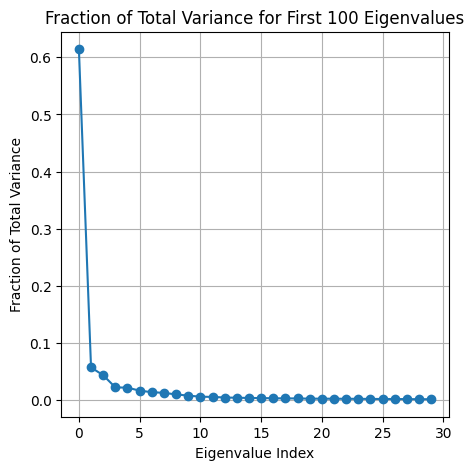

Effective Rank: 2.600273370742798
‖F-F_r1‖_F = 642486.125


In [29]:
plt.figure(figsize=(5, 5))
plt.plot(eigs[:30].detach().cpu().numpy() / eigs.sum().detach().cpu().numpy(), marker='o')
plt.xlabel("Eigenvalue Index")
plt.ylabel("Fraction of Total Variance")
plt.title("Fraction of Total Variance for First 100 Eigenvalues")
plt.grid()
plt.show()

effective_rank = eigs.sum() ** 2 / (eigs ** 2).sum()
print(f"Effective Rank: {effective_rank.item()}")

λ1 = eigs[0]
u1 = vecs[:, 0]
F_r1 = λ1 * u1.unsqueeze(1) @ u1.unsqueeze(0)
err_r1 = torch.linalg.norm(F.to(device) - F_r1)       # Frobenius norm
print(f"‖F-F_r1‖_F = {err_r1:.3f}")

In [ ]:
# let's try DDPM
class unet(nn.Module):
    def __init__(self, in_channels=1, latent_dim=8):
        super(unet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(), 
            nn.Linear(16 * 7 * 7, latent_dim),
        )
        # self.fc_mu = nn.Linear(16 * 7 * 7, latent_dim)
        # self.fc_logvar = nn.Linear(16 * 7 * 7, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (16, 7, 7)),
            nn.ConvTranspose2d(16, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, in_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        rec = self.decoder(self.encoder(x))
        return {"sample": rec}
    
scheduler = NoiseScheduler(timesteps=1000, device=device)
ddpm = DDPM(unet=unet, scheduler=scheduler, n_classes=0, device=device)